In [1]:
import torch

from src.modules import TabNetNoEmbeddings, TabNet, TabNetPretraining
from arguments import (ModelArguments, DataArguments)
from dataset import TabularDataset, TestTabularDataset, EasyTabularDataset

import torch
from torch import nn
from torch.utils.data import DataLoader

from tqdm import tqdm

import matplotlib.pyplot as plt

import PIL
from PIL import Image

from torchvision.transforms.functional import to_pil_image

In [2]:
def Equalize(img: Image) -> Image:
    return PIL.ImageOps.equalize(img)

In [3]:
def Invert(img: Image) -> Image:
    return PIL.ImageOps.invert(img)

In [4]:
model_args = ModelArguments
data_args = DataArguments

device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' ) #'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
model = TabNet(
    model_args.input_dim,
    model_args.output_dim,
    model_args.n_d,
    model_args.n_a,
    model_args.n_steps,
    model_args.gamma,
    [],
    [],
    model_args.cat_emb_dim,
    model_args.n_independent,
    model_args.n_shared,
    model_args.virtual_batch_size,
    model_args.momentum,
    model_args.epsilon,
    ).to(device)

In [7]:
model.load_state_dict(torch.load('./src/model/pretrain_easy_model.pt', map_location=device))

model.eval()

dataset = EasyTabularDataset(model_args, data_args)

In [16]:
dataset.data.columns

'magicDamageDealt_0_l'

In [8]:
M_explains = []
for x, label in tqdm(dataset):
    M_explain, _ = model.forward_masks(x.view(1,-1).to(device))
    M_explains.append(M_explain[0].detach().cpu())
M_explains = torch.stack(M_explains)

100%|██████████| 35408/35408 [12:47<00:00, 46.13it/s]


In [22]:
M_explains.shape

torch.Size([35408, 350])

In [9]:
t = torch.sum(M_explains, dim=0).view(1,-1)

주요 피처

In [20]:
max_M_explains = [t[0].tolist().index(i) for i in sorted(t[0].tolist(), reverse=True)[:20]]

In [21]:
[dataset.data.columns[i] for i in max_M_explains]

['turretsLost_4_l',
 'turretsLost_6_l',
 'turretsLost_3_l',
 'turretsLost_1_l',
 'wardsKilled_1_l',
 'physicalDamageDealtToChampions_5_l',
 'turretsLost_0_l',
 'assists_3_l',
 'deaths_7_l',
 'trueDamageTaken_7_l',
 'totalMinionsKilled_5_l',
 'dragonKills_0_l',
 'damageDealtToObjectives_1_l',
 'magicDamageTaken_4_l',
 'turretsLost_8_l',
 'wardsPlaced_9_l',
 'neutralMinionsKilled_7_l',
 'totalHeal_4_l',
 'neutralMinionsKilled_2_l',
 'turretKills_8_l']

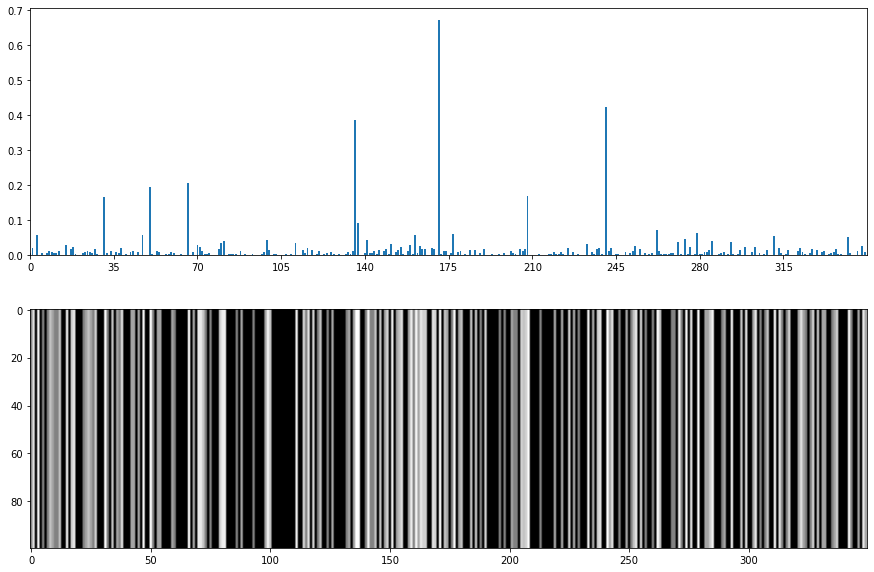

<PIL.Image.Image image mode=L size=350x1 at 0x7F7F783D81D0>


In [12]:
t = torch.sum(M_explains, dim=0).view(1,-1)
t = torch.nn.functional.normalize(t)
t = t
fig, axes = plt.subplots(2, 1, figsize=(15,10))

axes[0].set_xlim(0,350)
axes[0].set_xticks([i*35 for i in range(10)])
axes[0].bar(range(len(t[0])), t[0])

axes[1].imshow(Equalize(to_pil_image(t).resize((350,100))), cmap='gray')
plt.show()
print(to_pil_image(t))

In [23]:
2e-2

0.02